### BB pilot data classification analysis
- Stimulus is 3 min of rest, 7, 8, 9, 10, 11, 12 Hz 
- 4 different adult controls, one invalid session
- Early version of the BCI paradigm
    - Using this data because it's been preprocessed by Grace
- Rationale for this analysis
    - Possible differences in power but unsure how to analyze
    - Trying classification to establish if a difference exists at all 
    - Narrow down specific frequencies and channels for future analyses 

In [71]:
# load libraries 
import numpy as np
import pandas as pd
import mne 
import matplotlib.pyplot as plt
import os

import copy
import glob

# libraries for time frequency analysis
import scipy.signal as signal 

# libraries for classification analysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder



from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.metrics import accuracy_score

### Load EEG data
- 4 pilot recordings using 3 min version of BB
    - One recording not valid
- No gap between stimuli 
- Picking one recording at a time

In [79]:
# set wd
working_dir = '/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/bb_fooof/'
#data_dir = '/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/big_epochs/'
data_dir_old = '/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/'
os.chdir(working_dir)

# get deid log
deid_log = pd.read_csv("./bblong_old_group_list.csv")
deid_log.columns = ["eegid","group"]
deid_log["eegid"] = deid_log["eegid"].astype(int)


# get list of files 
file_list = glob.glob(data_dir_old + '*.set')
file_list.sort()

# join file list with group list to get final file list 
df_tmp = pd.DataFrame(file_list, columns = ['file_path'])
df_tmp['eegid'] = [os.path.basename(path)[0:4] for path in df_tmp['file_path']]
df_tmp['eegid'] = df_tmp['eegid'].astype(int)
df_filelist = deid_log.merge(df_tmp, on='eegid', how='left')

df_filelist = df_filelist.dropna()
df_filelist


,eegid,group,file_path
0,336,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
1,388,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
2,836,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
3,1498,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
4,1646,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
5,1655,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
6,1969,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
7,2481,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
8,2560,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...
9,2808,unknown,/srv/Analysis/Sri_Projects/entrain_bblong_09-0...


# Outline
- Pool epoch data from all subjects
- Group into stimulus frequencies
- subject * channel * epoch * time  

- stim_type * channel * time * freq * epochs 
- 9 stimuli * 128 chan * 250 ms * 20 Hz * 30 epochs

In [80]:

def subdivide_epochs_bblong(original_epochs, duration=2):
    """Subdivide epoched EEG data into smaller epochs, maintaining parent event type"""

    # list of epochs to concat later    
    epochs_list_to_concat_later = []

    # get event information 
    event_id = cur_eeg.event_id

    # loop through existing epochs
    for cur_event_name, cur_event_int in event_id.items():
        
        # create raw object from current epoch
        cur_epoch = original_epochs[cur_event_name]
        
        #Reshape so that the data becomes 2 dimensional
        cur_dat = cur_epoch.get_data().reshape(original_epochs.info['nchan'], -1)
        
        cur_info = cur_epoch.info     
        cur_converted_raw =  mne.io.RawArray(cur_dat, cur_info, verbose='ERROR')
        
        # create new epochs
        new_epochs = mne.make_fixed_length_epochs(
            cur_converted_raw,
            duration=duration,
            preload=True,
            id = cur_event_int,
            verbose='ERROR'
        )  
        
        # fix/set event_id dictionary so it matches original 
        new_epochs.event_id = event_id
        
        # add current epochs to running list
        epochs_list_to_concat_later.append(new_epochs)
        
    final_epochs = mne.concatenate_epochs(epochs_list_to_concat_later, verbose='ERROR')
    
    return final_epochs



In [81]:
# list of sitmuli
#stimulus_list = [
    #'rest',
    #'sham',
    #'7_hz_stimulus',
    #'8_hz_stimulus',
    #'9_hz_stimulus',
    #'10_hz_stimulus',
    #'11_hz_stimulus',
    #'12_hz_stimulus',
    #'13_hz_stimulus',
#]
stimulus_list = [
    'sham',
    '7_hz_stimulus',
    '9_hz_stimulus',
    '11_hz_stimulus',
    '13_hz_stimulus',
]


# initialize dict w/ stimulus types
pow_dict = {x: [] for x in stimulus_list}

# loop through eeg files 
for row_idx, row in df_filelist.iterrows():

    # load EEG
    cur_file = row['file_path']
    cur_eeg = mne.io.read_epochs_eeglab(cur_file, verbose='ERROR')
        
    # resample 
    srate = 125
    cur_eeg.resample(srate, verbose='ERROR')
 
    # subdivide epochs into 2sec epochs 
    subdivided_epochs = subdivide_epochs_bblong(cur_eeg, duration=2)

    # compute tfr
    power = subdivided_epochs.compute_psd(
        method='multitaper',
        fmin=2,
        fmax=30,
        verbose='ERROR'
    )
    ch_names = power.ch_names
    freqs = power.freqs
    
    
    print(row_idx)
    print(row)
    print(cur_file)
    
    
    # add tfr to corresponding key in dict
    for cur_stim in stimulus_list:
        pow_dict[cur_stim].append(power[cur_stim].data)
        
        

# stack lists into arrays and reshape subjects across epochs
pow_dict_pooled = {}
for cur_stim in pow_dict:
    
    # stack arrays and pool epochs across all s5ubjects
    # stacked_arr = np.stack(pow_dict[cur_stim])    
    # pow_dict[cur_stim] = stacked_arr.reshape(-1, len(ch_names), len(freqs))
    
    
    pow_dict_pooled[cur_stim] = np.concatenate(pow_dict[cur_stim], axis=0)

    

/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


0
eegid                                                      336
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 0, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/0336_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


1
eegid                                                      388
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 1, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/0388_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


2
eegid                                                      836
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 2, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/0836_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


3
eegid                                                     1498
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 3, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/1498_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


4
eegid                                                     1646
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 4, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/1646_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


5
eegid                                                     1655
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 5, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/1655_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


6
eegid                                                     1969
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 6, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/1969_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


7
eegid                                                     2481
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 7, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/2481_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


8
eegid                                                     2560
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 8, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/2560_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


9
eegid                                                     2808
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 9, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/2808_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


10
eegid                                                     2818
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 10, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/2818_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


11
eegid                                                     2920
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 11, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/2920_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


12
eegid                                                     2978
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 12, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/2978_BBLong_preprocessed.set


/opt/anaconda3/envs/entrain_analysis_env/lib/python3.12/site-packages/pymatreader/utils.py:291: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn(


14
eegid                                                     3416
group                                                  unknown
file_path    /srv/Analysis/Sri_Projects/entrain_bblong_09-0...
Name: 14, dtype: object
/srv/Analysis/Sri_Projects/entrain_bblong_09-04-2024/Preprocessed_files/old_BBLong_odd_only/3416_BBLong_preprocessed.set


In [82]:
power.event_id

{'rest': 1,
 'sham': 2,
 '11_hz_stimulus': 3,
 '13_hz_stimulus': 4,
 '9_hz_stimulus/rest': 5,
 '7_hz_stimulus': 6}

In [83]:
pow_dict.keys()

dict_keys(['sham', '7_hz_stimulus', '9_hz_stimulus', '11_hz_stimulus', '13_hz_stimulus'])

In [85]:
pow_dict_pooled["sham"].shape

(420, 128, 57)

In [84]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle


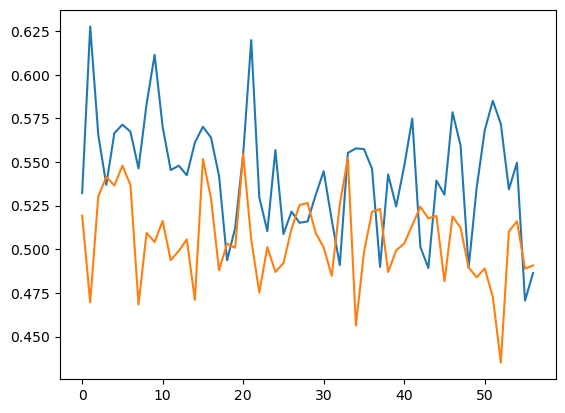

In [88]:

# classify AT EACH FREQUENCY, CHANNELS ARE USED AS FEATURES
def calc_crossval_score(
    pow_dict_pooled, 
    feature_2_keep,
    stim1,
    stim2,
     
    n_splits = 5, 
    svm_kernel = 'rbf'
):
    
    scores = []
    scores_shuffled = []
    
    
    # select stimuli to compare and combine epochs together
    dat1 = pow_dict_pooled[stim1]
    dat2 = pow_dict_pooled[stim2]
    dat_all = np.concatenate((dat1, dat2), axis=0)  

    # create labels
    y = np.concatenate((np.zeros(dat1.shape[0]), np.ones(dat2.shape[0])))
    
    
    
    
    
    # cross validation scheme
    cv = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state=1)

    # svm classifier
    clf = make_pipeline(StandardScaler(), SVC(kernel = svm_kernel))
    
    
    
    if feature_2_keep == 'channel':
        n_features = dat_all.shape[1]
    elif feature_2_keep == 'frequency':
        n_features = dat_all.shape[2]
    else:
        raise ValueError('feature_2_keep must be channel or frequency')
        
    for feature_idx in range(n_features):
        

        if feature_2_keep == 'channel':
            X = dat_all[:, feature_idx, :].reshape(len(y), -1)
        elif feature_2_keep == 'frequency':
            X = dat_all[:, feature_idx].reshape(len(y), -1)
    
        y_shuf = np.random.permutation(y)

        scores.append(
            np.mean(cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv))
        )
        scores_shuffled.append(
            np.mean(cross_val_score(estimator=clf, X=X, y=y_shuf, scoring="roc_auc", cv=cv))
        )

    
    # return scores and 'null' shuffled scores
    return (scores, scores_shuffled)


scores, scores_shuffled = calc_crossval_score(
    pow_dict_pooled = pow_dict_pooled, 
    feature_2_keep = 'frequency',
    stim1 = "sham",
    stim2 = "11_hz_stimulus",
     
    n_splits = 5, 
    svm_kernel = 'rbf'
)

plt.plot(scores, label="stimulus")
plt.plot(scores_shuffled, label="shuffled null")

In [ ]:
# Create a dummy info structure
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
info = mne.create_info(ch_names=montage.ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage, match_case = False)

# Create an Evoked object with the data_array
evoked = mne.EvokedArray(np.stack(np.array(scores), np.array(scores_shuffled), axis = 1), info)

# plot topomap
fig, ax = plt.subplots()
img, _ = mne.viz.plot_topomap(
    data = scores, 
    pos = info,
    size = 4, 
    show = False,
    vlim = (0, 1), 
    cmap = 'Spectral_r', 
    axes = ax
)
cbar = plt.colorbar(ax = ax, shrink = 0.75, orientation = 'vertical', mappable = img)

plt.title('Classification score')

In [ ]:
len(pow_dict[stimulus])

In [ ]:

# Assuming data_dict is your original dictionary of arrays
stimuli_keys = np.array(list(pow_dict.keys()))  # List of stimuli keys
reshaped_data = []  # To hold the reshaped arrays
stimuli_key_list = []  # To hold the corresponding stimuli for each flattened entry

for stimulus in stimuli_keys:
    # Get the array for the current stimulus
    arr = np.stack(pow_dict[stimulus])  # Shape (11, 30, 128, 57)
    
    # Reshape it to (11 * 30, 128 * 57) and append to reshaped_data
    reshaped = arr.reshape(11 * 30, 128 * 57)  # Shape (330, 128 * 57)
    reshaped_data.append(reshaped)
    
    # Create a list with the stimulus repeated for each of the 330 entries
    stimuli_key_list.extend([stimulus] * (11 * 30))

# Stack all reshaped arrays into one big array of shape (2970, 128 * 57)
reshaped_data = np.vstack(reshaped_data)  # Shape (2970, 128 * 57)

# stimuli_key_list will have length 2970, where each entry corresponds to a stimulus

# Create a dictionary that assigns a unique integer to each unique string
unique_dict = {value: idx + 1 for idx, value in enumerate(sorted(set(stimuli_key_list)))}

# Replace strings in the original list with their corresponding integer values
labels = [unique_dict[value] for value in stimuli_key_list]


In [ ]:

# standardize
tfr_standardized = StandardScaler().fit_transform(reshaped_data)


# pca
pca = PCA(n_components = 5)
principleComponents = pca.fit_transform(tfr_standardized)


# check % variance 
print(np.shape(principleComponents))
print(pca.explained_variance_ratio_)



# plot
fig, ax = plt.subplots()

plt.xlabel("PC1") 
plt.ylabel("PC2")

scatter = plt.scatter(principleComponents[:,4], 
            principleComponents[:,3], 
            #c = stimuli_key_list, 
            c = labels,
            cmap = 'turbo')
legend = ax.legend(*scatter.legend_elements(), 
                   loc = "upper right")

plt.title('averaged across channels + all frequencies')

In [ ]:
# Create a dummy info structure
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
info = mne.create_info(ch_names=montage.ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage, match_case = False)

# Create an Evoked object with the data_array
evoked = mne.EvokedArray(scores, info)

# plot topomap
fig, ax = plt.subplots()
img, _ = mne.viz.plot_topomap(
    data = scores.flatten(), 
    pos = info,
    size = 4, 
    show = False,
    vlim = (0, 1), 
    cmap = 'Spectral_r', 
    axes = ax
)
cbar = plt.colorbar(ax = ax, shrink = 0.75, orientation = 'vertical', mappable = img)

plt.title('Classification score, ' + str(stim1) + " Hz vs " + str(stim2))

### Notes from Wed meeting 
- Try shuffling frequencies
- Test with white noise
- Narrow band pass filter could cause issues
- Currently we don't know what the classification is picking up on 
- Need to try other features to identify what the model is picking up on  
    - PAC
    - Known/established differences in amplitude and phase

### Other problems 
- Baseline/rest and 12 Hz are very far apart in time
    - Time could be conflated with stimulation
    - Need to do pilots with random order  
- Don't know what feature of time frequency signal is different, only that they're different
- Overfitting 





### Notes from Tuesday morning 

- Compare subjects based on effect sizes
- Other features: pac amplitude coupling, other connectivity
- Try the new pilot data 
    - compare each stimulus with subsequent ITI
- Need to establish wash out effect after each stimulus 


- Summarize graph 
- Break into frequency bands - average into frequency bands
- 

In [ ]:


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# parameters for TFR calculation
freqs = np.arange(2, 55)
cycles = np.linspace(1, 30, len(freqs))
roi = ['E28', 'E20', 'E12', 'E5', 'E118', 'E117', 'E29', 'E13', 'E6', 'E112', 'E111', 'E36', 'E30', 'E7', 'E106', 'E105', 'E104', 'E31', 'E80', 'E55', 'E37', 'E87', 'E41', 'E103']





# calculate TFR --> average across time
tfr = calc_bb_tfr(
    epoch = epoch, 
    freqs = freqs, 
    cycles = cycles, 
    dimensions_2_average = 3
)

# select channels and stimuli to keep
labels = epoch.events[:, 2]



print(tfr.shape)
print(labels.shape)


In [ ]:
from sklearn.decomposition import PCA

# reshape
tfr_sel = np.mean(tfr, axis = 1)
tfr_reshaped = tfr_sel.reshape(tfr_sel.shape[0], -1)


# standardize
tfr_standardized = StandardScaler().fit_transform(tfr_reshaped)


# pca
pca = PCA(n_components = 5)
principleComponents = pca.fit_transform(tfr_standardized)


# check % variance 
print(np.shape(principleComponents))
print(pca.explained_variance_ratio_)



# plot
fig, ax = plt.subplots()

plt.xlabel("PC1") 
plt.ylabel("PC2")

scatter = plt.scatter(principleComponents[:,0], 
            principleComponents[:,1], 
            c = labels, 
            cmap = 'turbo')
legend = ax.legend(*scatter.legend_elements(), 
                   loc = "upper right")

plt.title('averaged across channels + all frequencies')